In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 395 (delta 92), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (395/395), 108.50 KiB | 6.03 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla V100-SXM2-16GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%load_ext cudf.pandas

In [ ]:
pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload() # Use this to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amubits","key":"8156d122b4ac3059d77cd70a16be601e"}'}

In [ ]:
# Make sure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API client
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c 'dogs-vs-cats-redux-kernels-edition'

100% 812M/814M [00:22<00:00, 39.3MB/s]
100% 814M/814M [00:22<00:00, 38.7MB/s]


In [ ]:
import os

os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
os.environ['LANGUAGE'] = 'en_US.UTF-8'

In [ ]:
!unzip 'dogs-vs-cats-redux-kernels-edition.zip'

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

In [ ]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [ ]:
!ls

dogs-vs-cats-redux-kernels-edition.zip	rapidsai-csp-utils     test	 train.zip
input					sample_data	       test.zip
kaggle.json				sample_submission.csv  train


In [ ]:
!mkdir input

In [ ]:
!mv train/  input/train

In [ ]:
!mv test/  input/test

In [ ]:
print(os.listdir("input"))

['sample_submission.csv', 'test', 'train']


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, Concatenate, concatenate
from keras.models import Model
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [ ]:
filenames = os.listdir("input/train")
labels = []
for file in filenames:
    category = file.split('.')[0]
    if category == 'cat':
        labels.append('cat')
    else:
        labels.append('dog')

In [ ]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})
train_df, validation_df = train_test_split(df, test_size=0.25, random_state = 42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [ ]:
train_df.head()

,filename,label
0,cat.4240.jpg,cat
1,cat.10564.jpg,cat
2,cat.4607.jpg,cat
3,dog.7774.jpg,dog
4,dog.11908.jpg,dog


In [ ]:
train_df.count()

filename    18750
label       18750
dtype: int64

In [ ]:
validation_df.head()

,filename,label
0,dog.7547.jpg,dog
1,cat.10104.jpg,cat
2,cat.9923.jpg,cat
3,cat.7361.jpg,cat
4,cat.7637.jpg,cat


In [ ]:
validation_df.count()

filename    6250
label       6250
dtype: int64

In [ ]:
batch_size = 64
train_num = len(train_df)
validation_num = len(validation_df)

In [ ]:
import keras
from tensorflow.keras.layers import Input, Lambda, Concatenate, Dense, Dropout
from tensorflow.keras.applications import vgg16, resnet50, inception_v3
from tensorflow.keras.models import Model
import tensorflow as tf

# Create base models with preprocessing included
def create_base_model(MODEL, preprocess_input, target_size):
    inp = Input(shape=(224, 224, 3))  # Common input size

    # If target size is different, resize input
    if target_size != (224, 224):
        x = Lambda(lambda image: tf.image.resize(image, target_size))(inp)
    else:
        x = inp

    # Apply model-specific preprocessing
    x = Lambda(preprocess_input)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')
    return Model(inp, base_model.output)

# Instantiate each model
model1 = create_base_model(vgg16.VGG16, vgg16.preprocess_input, (224, 224))
model2 = create_base_model(resnet50.ResNet50, resnet50.preprocess_input, (224, 224))
model3 = create_base_model(inception_v3.InceptionV3, inception_v3.preprocess_input, (299, 299))

# Set the models as non-trainable
model1.trainable = False
model2.trainable = False
model3.trainable = False

# Define a single input
inp = Input(shape=(224, 224, 3))

# Get outputs from each model
out1 = model1(inp)
out2 = model2(inp)
out3 = model3(inp)

# Concatenate outputs and add final layers
x = Concatenate()([out1, out2, out3])
x = Dropout(0.6)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the final model
multiple_pretained_model = Model(inp, x)

# Compile the model
multiple_pretained_model.compile(loss='binary_crossentropy',
                                 optimizer='rmsprop',
                                 metrics=['accuracy'])

# Model summary
multiple_pretained_model.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_18 (Functional)       (None, 512)                  1471468   ['input_32[0][0]']            
                                                          8                                       
                                                                                                  
 model_19 (Functional)       (None, 2048)                 2358771   ['input_32[0][0]']            
                                                          2                                       
                                                                                           

**This script creates a neural network model that leverages the capabilities of three well-known pre-trained models: VGG16, ResNet50, and InceptionV3.The models are loaded with pre-trained weights from ImageNet, and their top layers are not included.The output of these models is pooled using global average pooling to reduce the dimensionality.The pre-trained models are set as non-trainable, meaning their weights will not be updated during training.The script then takes the output of each pre-trained model (which is now a feature vector due to the pooling operation) and concatenates them into a single, longer feature vector. This creates a rich representation of the input image by combining features extracted by all three models.After concatenation, a dropout layer is added to prevent overfitting by randomly setting a fraction of the input units to 0 during training.A dense layer with a single neuron and sigmoid activation function follows, which indicates that the final model is designed for a binary classification task.The entire model is designed to leverage the learned patterns from the ImageNet dataset (through the pre-trained models) to predict binary outcomes for new images, without training the pre-trained models further (hence, they are frozen)**

In [ ]:
def single_image_generator(generator, dataframe, directory, batch_size, y_col=None, model=None, shuffle=False):
    gen = generator.flow_from_dataframe(
        dataframe,
        directory=directory,
        x_col='filename',
        y_col=y_col,
        class_mode=model,
        target_size=(224, 224),  # Use a single size for all inputs
        batch_size=batch_size,
        shuffle=shuffle
    )

    while True:
        batch = gen.next()
        if y_col:
            yield batch[0], batch[1]  # Yield image inputs and labels
        else:
            yield batch  # Yield only image inputs

In [ ]:
train_aug_datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.1,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)

In [ ]:
validation_datagen = ImageDataGenerator()

In [ ]:
train_generator = single_image_generator(train_aug_datagen, train_df, 'input/train',
                                         batch_size=batch_size, y_col='label',
                                         model='binary', shuffle=True)
validation_generator = single_image_generator(validation_datagen, validation_df,
                                              'input/train', batch_size=batch_size,
                                              y_col='label', model='binary', shuffle=True)


**Only training with 3 epochs as I notcied that if I increase epochs the accuracy is decreasing and also the kaggle score increased from 0.045 to 0.47**

In [ ]:
history = multiple_pretained_model.fit(
    train_generator,
    epochs = 3,
    steps_per_epoch = train_num // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_num // batch_size,
    verbose = 1
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1029: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[x_col].apply(lambda x: isinstance(x, str))):
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1035: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[y_col].apply(lambda x: isinstance(x, str))):


Found 18750 validated image filenames belonging to 2 classes.
Epoch 1/3
585/585 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9670Found 6250 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1029: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[x_col].apply(lambda x: isinstance(x, str))):
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1035: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[y_col].apply(lambda x: isinstance(x, str))):


585/585 [==============================] - 253s 417ms/step - loss: 0.1013 - accuracy: 0.9670 - val_loss: 0.0444 - val_accuracy: 0.9878
Epoch 2/3
585/585 [==============================] - 241s 409ms/step - loss: 0.0559 - accuracy: 0.9834 - val_loss: 0.0275 - val_accuracy: 0.9921
Epoch 3/3
585/585 [==============================] - 236s 404ms/step - loss: 0.0551 - accuracy: 0.9848 - val_loss: 0.0260 - val_accuracy: 0.9934


In [ ]:
val_loss, val_accuracy = multiple_pretained_model.evaluate(validation_generator, steps=validation_num // batch_size)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_accuracy)

195/195 [==============================] - 22s 114ms/step - loss: 0.0271 - accuracy: 0.9932
Validation loss: 0.027068806812167168
Validation accuracy: 0.9932454228401184


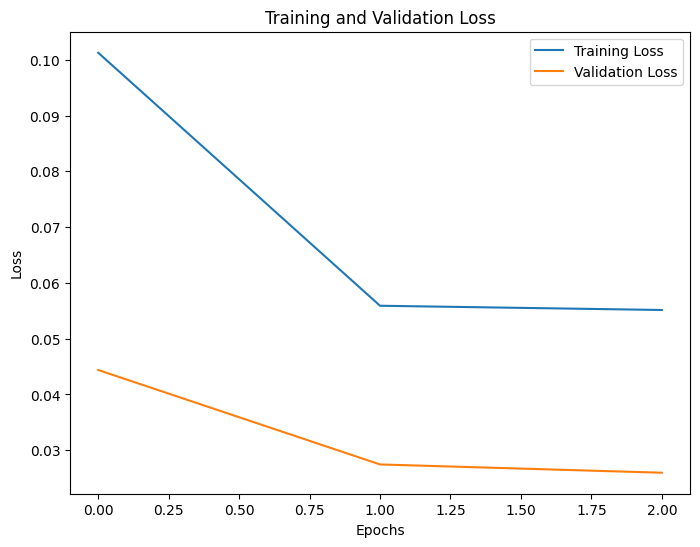

In [ ]:
plt.figure(figsize=(8, 6))

# Training loss
plt.plot(history.history['loss'], label='Training Loss')

# Validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

**Both training and validation loss are decreasing, which is a good sign. It indicates that the model is learning and improving its performance on both the training data and unseen validation data. The training and validation loss lines appear to be converging, which suggests that the model is not overfitting. Overfitting would be indicated by a continued decrease in training loss, but an increase or plateau in validation loss.The validation loss appears relatively stable between the first and second epoch, which might suggest that the model has reached a point where further training doesn't significantly improve performance on the validation set. If the validation loss stops decreasing and starts to increase while the training loss continues to decrease, it's a sign that the model is starting to memorize the training data and losing its ability to generalize. That does not seem to be happening here**

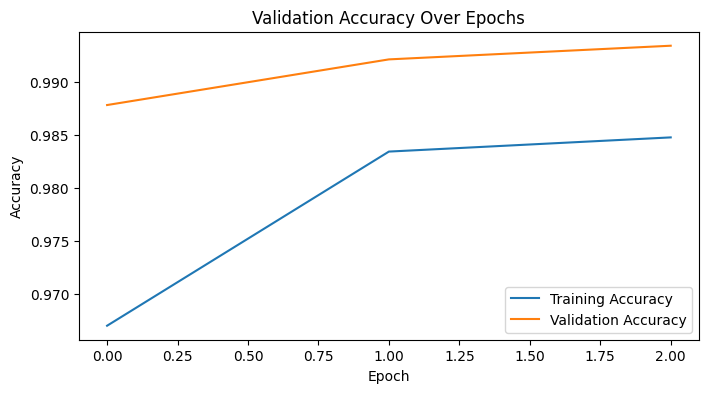

In [ ]:
# Plot the validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**Overfitting is usually identified when the training accuracy continues to increase while validation accuracy decreases. However, in this graph, both accuracies are increasing, with the validation accuracy being higher than the training accuracy, indicating that overfitting is not occurring within the observed epochs. The graph indicates a well-performing model with high accuracy on both training and validation sets over two epochs, without signs of overfitting. The model appears to be learning effectively and generalizing well to unseen data**

In [ ]:
test_filenames = os.listdir("input/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
num_test = len(test_df)

test_datagen = ImageDataGenerator()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def single_image_generator(datagen, dataframe, directory, batch_size, target_size=(224, 224)):
    gen = datagen.flow_from_dataframe(
        dataframe,
        directory=directory,
        x_col='filename',
        y_col=None,  # No labels needed for prediction
        class_mode=None,  # For prediction, we don't need labels
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle for prediction
    )
    return gen

# Create the test generator
test_datagen = ImageDataGenerator()
test_generator = single_image_generator(test_datagen, test_df, 'input/test', batch_size)


Found 12500 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1029: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if not all(df[x_col].apply(lambda x: isinstance(x, str))):


In [ ]:
# Predict
prediction = multiple_pretained_model.predict(
    test_generator,
    steps=np.ceil(num_test / batch_size)
)
prediction = prediction.clip(min=0.005, max=0.995)

391/391 [==============================] - 46s 113ms/step


In [ ]:
submission_df = pd.read_csv('input/sample_submission.csv')
for i, fname in enumerate(test_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    submission_df.at[index-1, 'label'] = prediction[i]
submission_df.to_csv('submission.csv', index=False)

In [ ]:
submission_df.head()

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005


In [ ]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
multiple_pretained_model.save('my_model.h5')

# To download it to your local machine from Google Colab
from google.colab import files
files.download('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>